# VQE with gradients, active spaces, and gate fusion



This tutorial will explore the Variational Quantum Eigensolver, a hybrid quantum classical algorithm for determining the ground state energy of molecules. The first part of this tutorial will walk through the key aspects of the VQE algorithm and how to implement it with CUDA-Q.  The following sections explore advanced topics: parallel gradients, active spaces, and gate fusion

## The Basics of VQE

The VQE algorithm is hybrid quantum-classical algorithm, meaning some subroutines run on a quantum computer or quantum simulator and others run on a traditional (super)computer.  

The goal is to take a parameterized quantum circuit and a qubit form of the molecular Hamiltonian, measure an expectation value that corresponds to the ground state energy of the molecule, and then repeat the process to variationally minimize the energy with respect to the parameters in the quantum circuit. The optimization is performed on a classical device while the expectation values are determined on a quantum device.  See the figure below.


![VQE.png](./images/VQE.png)



The next few cells will elaborate on each part of the VQE procedure and show you how to build a VQE simulation to compute the ground state energy of the water molecule.

## Installing/Loading Relevant Packages

In [1]:
# Install the relevant packages.
!pip install pyscf==2.6.2 openfermionpyscf==0.5 matplotlib==3.8.4 openfermion==1.6.1 -q

In [2]:
import openfermion
import openfermionpyscf
from openfermion.transforms import jordan_wigner, get_fermion_operator

import os
import timeit

import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

## Implementing VQE in CUDA-Q

Like most quantum chemistry programs, the first step is to specify a molecular geometry, basis set, charge, and multiplicity. 

In [3]:
geometry = [('O', (0.1173, 0.0, 0.0)), ('H', (-0.4691, 0.7570, 0.0)),
            ('H', (-0.4691, -0.7570, 0.0))]
basis = 'sto3g'
multiplicity = 1
charge = 0

The VQE procedure requires some classical preprocessing.  The code below uses the PySCF package and OpenFermion to compute the Hartree Fock reference state and compute the integrals required for the Hamiltonian.

In [4]:
molecule = openfermionpyscf.run_pyscf(
    openfermion.MolecularData(geometry, basis, multiplicity, charge))

Next, the Hamiltonian is built using `get_molecular_hamiltonian`. The Hamiltonian must then be converted to a qubit Hamiltonian consisting of qubit operators. The standard Jordan-Wigner transformation is used to perform this mapping. 

Finally, the Jordan-Wigner qubit Hamiltonian is converted into a CUDA-Q spin operator which can be used to evaluate an expectation value given a quantum circuit.

In [5]:
molecular_hamiltonian = molecule.get_molecular_hamiltonian()

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)

qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham = cudaq.SpinOperator(qubit_hamiltonian)

Next, the quantum circuit needs to be defined, which models the wavefunction. This is done in CUDA-Q by specifying a CUDA-Q kernel. The kernel takes as an input the number of qubits, the number of electrons, and the parameters of the circuit ansatz (form of the wavefunction) yet to be defined. 

The number of qubits corresponds to the potential positions of electrons and is therefore twice the number of spatial orbitals constructed with the chosen basis set, as each can be occupied by two electrons. 

The Hartree-Fock reference is constructed by applying $X$ bitflip operations to each of the first $N$ qubits where $N$ is the number of electrons. Next, a parameterized ansatz is chosen. Theoretically, any set of operations can work as an ansatz, however, it is good practice to use an ansatz that captures the underlying physics of the problem. The most common choice for chemistry is the Unitary Coupled Cluster Ansatz with Single and Double excitations (UCCSD).  This UCCSD hate operations are automatically added to the kernel with the `cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)` function. 

The STO-3G water molecuule UCCSD ansatz requires optimization of 140 parameters.

In [6]:
electron_count = 10
qubit_count = 2 * 7


@cudaq.kernel
def kernel(qubit_num: int, electron_num: int, thetas: list[float]):
    qubits = cudaq.qvector(qubit_num)

    for i in range(electron_num):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)


parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

print(parameter_count)

140


The classical optimizer requires a custom cost function which is defined below. The `cudaq.observe()` function computes an expectation given the Hamiltonian and the kernel defined above.

In [7]:
def cost(theta):

    exp_val = cudaq.observe(kernel, spin_ham, qubit_count, electron_count,
                            theta).expectation()

    return exp_val


exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, 1, parameter_count)

The final step is to run the optimization using the scipy minimize function and a selected optimizer, in this case COBYLA. 

UCCSD-VQE energy =   -70.21455023422776
Total number of qubits =  14
Total number of parameters =  140
Total number of terms in the spin hamiltonian =  1086
Total elapsed time (s) =  3.8620868140000084


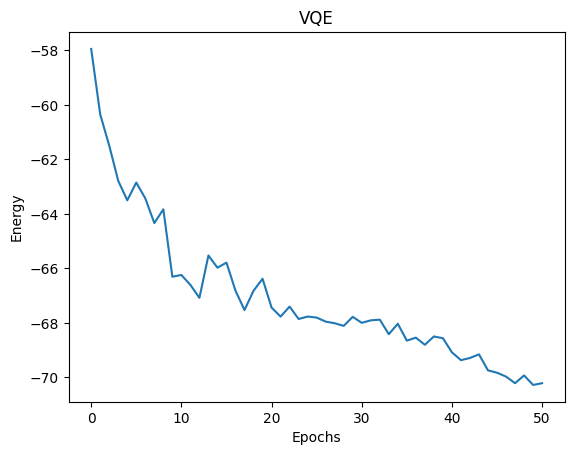

In [8]:
cudaq.set_target('nvidia')
start_time = timeit.default_timer()
result = minimize(cost,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 50})
end_time = timeit.default_timer()

print('UCCSD-VQE energy =  ', result.fun)
print('Total number of qubits = ', qubit_count)
print('Total number of parameters = ', parameter_count)
print('Total number of terms in the spin hamiltonian = ',
      spin_ham.get_term_count())
print('Total elapsed time (s) = ', end_time - start_time)

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

The result of this procedure is an estimate of the ground state energy of water. However, the convergence behavior is not perfect, more iterations would greatly improve the result, but would take a few minutes to run.

## Parallel Parameter Shift Gradients

One way to accelerate VQE is to use an optimizer that accepts a gradient. This can drastically lower the number of VQE iterations required at the cost of computing the gradient on the quantum side of the algorithm.

The parameter shift rule is a common technique to compute the gradient for parameterized circuits. It is obtained by computing two expectation values for each parameter corresponding to a small forward and backward shift in the ith parameter. These results are used to estimate  finite difference contribution to the gradient.

![parametershift.png](./images/parametershift.png)

This procedure can become cost prohibitive as the number of parameters becomes large.

Each of the expectation values needed to evaluate a parameter shift gradient can be computed independently.  The CUDA-Q `nvidia-mqpu` backend is designed for parallel computations across multiple simulated QPUs. The function below uses `cudaq.observe_asynch` to distribute all of the expectation values evaluations across as many GPUs that are available. First, try it with `num_qpus` set to 1.

In [9]:
np.random.seed(42)
x0 = np.random.normal(0, 1, parameter_count)

cudaq.set_target("nvidia-mqpu")

num_qpus = cudaq.get_target().num_qpus()

epsilon = np.pi / 4


def batched_gradient_function(kernel, parameters, hamiltonian, epsilon):

    x = np.tile(parameters, (len(parameters), 1))

    xplus = x + (np.eye(x.shape[0]) * epsilon)

    xminus = x - (np.eye(x.shape[0]) * epsilon)

    g_plus = []
    g_minus = []
    gradients = []

    qpu_counter = 0  # Iterate over the number of GPU resources available
    for i in range(x.shape[0]):

        g_plus.append(
            cudaq.observe_async(kernel,
                                hamiltonian,
                                qubit_count,
                                electron_count,
                                xplus[i],
                                qpu_id=qpu_counter%num_qpus))
        qpu_counter += 1

        g_minus.append(
            cudaq.observe_async(kernel,
                                hamiltonian,
                                qubit_count,
                                electron_count,
                                xminus[i],
                                qpu_id=qpu_counter%num_qpus))
        qpu_counter += 1

        if qpu_counter % num_qpus == 0:
            qpu_counter = 0

    gradients = [
        (g_plus[i].get().expectation() - g_minus[i].get().expectation()) /
        (2 * epsilon) for i in range(len(g_minus))
    ]

    assert len(gradients) == len(
        parameters) == x.shape[0] == xplus.shape[0] == xminus.shape[0]

    return gradients

[warning] Target nvidia-mqpu: This target is deprecating. Please use the 'nvidia' target with option 'mqpu,fp32' or 'mqpu' (fp32 is the default precision option) by adding the command line option '--target-option mqpu,fp32' or passing it as cudaq.set_target('nvidia', option='mqpu,fp32') in Python. Please refer to CUDA-Q ]8;;https://nvidia.github.io/cuda-quantum/latest/using/backends/platform.html#nvidia-mqpu-platform\documentation]8;;\ for more information.


The cost function needs to be slightly updated to make use of the gradient in the optimization procedure and allow for a gradient based optimizer like L-BFGS-B to be used.

In [10]:
gradient = batched_gradient_function(kernel, x0, spin_ham, epsilon)

exp_vals = []


def objective_function(parameter_vector: list[float], \
                       gradient=gradient, hamiltonian=spin_ham, kernel=kernel):

    get_result = lambda parameter_vector: cudaq.observe\
        (kernel, hamiltonian, qubit_count, electron_count, parameter_vector).expectation()

    cost = get_result(parameter_vector)
    exp_vals.append(cost)
    gradient_vector = batched_gradient_function(kernel, parameter_vector,
                                                spin_ham, epsilon)

    return cost, gradient_vector

Run the code below. Notice how the result is converged to a lower energy using only 10% of the steps as optimization above without a gradient. 

VQE-UCCSD energy=  -73.19471262288752
Total elapsed time (s) =  56.45545761200003


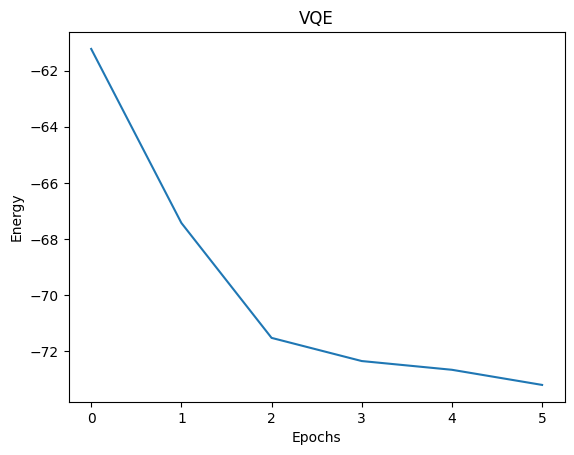

In [11]:
np.random.seed(42)
init_params = np.random.normal(0, 1, parameter_count)

start_time = timeit.default_timer()
result_vqe = minimize(objective_function,
                      init_params,
                      method='L-BFGS-B',
                      jac=True,
                      tol=1e-8,
                      options={'maxiter': 5})
end_time = timeit.default_timer()

print('VQE-UCCSD energy= ', result_vqe.fun)
print('Total elapsed time (s) = ', end_time - start_time)

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

Now, run the code again (the three previous cells) and specify `num_qpus` to be more than one if you have access to multiple GPUs and notice resulting speedup.  Thanks to CUDA-Q, this code could be used without modification in a setting where multiple physical QPUs were availible.

## Using an Active Space

Performing electronic structure computations with all electrons and orbitals is often prohibitively expensive and unnecessary.  Most of the interesting chemistry can be modeled by restricting simulations to the highest energy occupied molecular orbitals and lowest energy unoccupied molecular orbitals. This is known as the active space approximation. 

Below is an example of STO-3G water modeled with a 4 electron 3 orbital active space simulated with UCCSD-VQE. Using an active space means you can run VQE for the same molecule using fewer qubits and a more shallow circuit.


![cas.png](./images/cas.png)

The molecule is defined the same way, expect for you now include variables `nele_cas` and `norb_cas` to define the active space. The `ncore` 

In [12]:
geometry = [('O', (0.1173, 0.0, 0.0)), ('H', (-0.4691, 0.7570, 0.0)),
            ('H', (-0.4691, -0.7570, 0.0))]
basis = 'sto3g'
multiplicity = 1
charge = 0
ncore = 3
nele_cas, norb_cas = (4, 3)

molecule = openfermionpyscf.run_pyscf(
    openfermion.MolecularData(geometry, basis, multiplicity, charge))

The Hamiltonian is now constrcuted with the same steps, but only models the active space.

In [13]:
molecular_hamiltonian = molecule.get_molecular_hamiltonian(
    occupied_indices=range(ncore),
    active_indices=range(ncore, ncore + norb_cas))

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)

qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham = cudaq.SpinOperator(qubit_hamiltonian)

Similarly, the kernel is defined only by the orbitals and electrons in the active space. Notice how this means you only need to optimize 8 parameters now. 

In [14]:
electron_count = nele_cas
qubit_count = 2 * norb_cas


@cudaq.kernel
def kernel(qubit_num: int, electron_num: int, thetas: list[float]):
    qubits = cudaq.qvector(qubit_num)

    for i in range(electron_num):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)


parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

print(parameter_count)

8


In [15]:
def cost(theta):

    exp_val = cudaq.observe(kernel, spin_ham, qubit_count, electron_count,
                            theta).expectation()
    thetas = theta
    return exp_val


exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, 1, parameter_count)

The VQE procedure below is much faster using an active space compared to inclusion of all orbitals and electrons.

UCCSD-VQE energy =   -74.96333919639714
Total number of qubits =  6
Total number of parameters =  8
Total number of terms in the spin hamiltonian =  62
Total elapsed time (s) =  1.7232954380000365


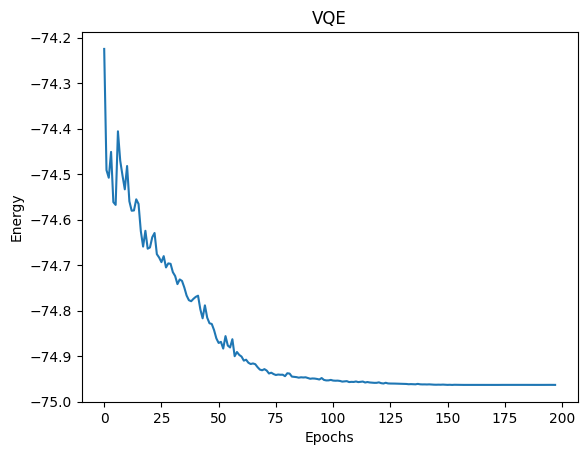

In [16]:
cudaq.set_target("nvidia")

start_time = timeit.default_timer()
result = minimize(cost,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 500})
end_time = timeit.default_timer()

print('UCCSD-VQE energy =  ', result.fun)
print('Total number of qubits = ', qubit_count)
print('Total number of parameters = ', parameter_count)
print('Total number of terms in the spin hamiltonian = ',
      spin_ham.get_term_count())
print('Total elapsed time (s) = ', end_time - start_time)

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

## Gate Fusion for Larger Circuits

CUDA-Q simulations take advantage of a technique called gate fusion. Gate fusion is an optimization technique where consecutive gates are combined into a single gate operation to improve the efficiency of the simulation (See figure below).  By targeting the `nvidia-mgpu` backend and setting the `CUDAQ_MGPU_FUSE` environment variable, you can select the degree of fusion that takes place. 

![gate-fuse.png](./images/gate-fuse.png)

This is particularly important for larger circuits and can have a significant impact on the performance of the simulation. Each system is different, so you should test different gate fusion levels to find out what is best for your system. You can find more information [here](https://developer.nvidia.com/blog/new-nvidia-cuda-q-features-boost-quantum-application-performance/).